# Practical about Feature Selection
Enrique Juliá Arévalo, Sara Verde Camacho, Leo Pérez Peña

### Librerías necesarias:

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

Comenzamos cargando los datos:

In [2]:
data = pd.read_csv('prostate.csv')
data.head()

,100_g_at,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,Y
0,6.927460,7.391657,3.812922,3.453385,6.070151,5.527153,5.812353,3.167275,7.354981,9.419909,...,3.770583,2.884436,2.730025,3.126168,2.870161,3.082210,2.747289,3.226588,3.480196,0
1,7.222432,7.329050,3.958028,3.407226,5.921265,5.376464,7.303408,3.108708,7.391872,10.539579,...,3.190759,2.460119,2.696578,2.675271,2.940032,3.126269,3.013745,3.517859,3.428752,1
2,6.776402,7.664007,3.783702,3.152019,5.452293,5.111794,7.207638,3.077360,7.488371,6.833428,...,3.325183,2.603014,2.469759,2.615746,2.510172,2.730814,2.613696,2.823436,3.049716,0
3,6.919134,7.469634,4.004581,3.341170,6.070925,5.296108,8.744059,3.117104,7.203028,10.400557,...,3.625057,2.765521,2.681757,3.310741,3.197177,3.414182,3.193867,3.353537,3.567482,0
4,7.113561,7.322408,4.242724,3.489324,6.141657,5.628390,6.825370,3.794904,7.403024,10.240322,...,3.698067,3.026876,2.691670,3.236030,3.003906,3.081497,2.963307,3.472050,3.598103,1


Y extrayendo las etiquetas, que están en la última columna:

In [3]:
X = np.array(data.iloc[:, :-1]).astype(float)
y = np.array(data.iloc[:, -1]).astype(int)
print(y)

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1]


**You are asked to:**

**1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-times 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.**

En primer lugar, tenemos que dividir el conjunto de datos en 10 partes (10-fold). De ellas, 9 se utilizarán para el entrenamiento del clasificador y una para el test. Este proceso se repite 10 veces (10-times).

Por otro lado, antes de entrenar el clasificador Nearest Neighbors, tenemos que averiguar qué número de vecinos (k) minimiza el error de predicción. Para ello, volvemos a dividir los datos en 5 partes. 4 de ellas se utilizarán para entrenar el clasificador K-Nearest-Neighbors (KNN) con cada número de vecinos, y una para testarlo. Este proceso se realizará con cada uno de los conjuntos de entrenamiento generados en el paso anterior, es decir, 10 veces.

Una vez seleccionado el mejor modelo, se utilizará para realizar las predicciones, que se compararán con las etiquetas reales del conjunto de test para calcular la precisión en cada caso.

La precisión global del clasificador será el promedio de las precisiones obtenidas. 

In [4]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar los valores de precisión obtenidos
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

time = 1

for train_idx, test_idx in out_cv.split(X, y):

    print(f"Time {time}")
    # Generamos los conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Normalizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Buscamos el mejor valor de n_neighbors para el clasificador KNN
    in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
    gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
    gridcv.fit(X_train_scaled, y_train)
    # Obtenemos el mejor modelo
    best_knn = gridcv.best_estimator_
    # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
    predictions = best_knn.predict(X_test_scaled)
    # Calculamos la precisión del modelo
    test_accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy this time: {test_accuracy}")
    # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
    accuracies.append(test_accuracy)

    time += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

Time 1
Accuracy this time: 0.9090909090909091
Time 2
Accuracy this time: 0.8181818181818182
Time 3
Accuracy this time: 0.8
Time 4
Accuracy this time: 0.7
Time 5
Accuracy this time: 0.8
Time 6
Accuracy this time: 0.9
Time 7
Accuracy this time: 1.0
Time 8
Accuracy this time: 0.8
Time 9
Accuracy this time: 0.8
Time 10
Accuracy this time: 0.6
Mean accuracy: 0.8127272727272727
Standard deviation of accuracy: 0.10517203537439689


**2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.**

Al código anterior le vamos a agregar un paso de selección de atributos basado en el F-score (ANOVA), que es una comparación de la varianza de cada característica entre clases con respecto a la varianza de dicha característica dentro de cada clase. Cuanto mayor es el F-score, más relevante es una característica a la hora de clasificar los datos.

Por tanto, antes de entrenar el clasificador KNN seleccionaremos los 10 atributos con mayor F-score.

In [5]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar los valores de precisión obtenidos
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

time = 1

for train_idx, test_idx in out_cv.split(X, y):

    print(f"Time {time}")
    # Generamos los conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Normalizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Seleccionamos los 10 atributos más relevantes según el F-score
    feature_selector = SelectKBest(f_classif, k=10)
    X_train_selection = feature_selector.fit_transform(X_train_scaled, y_train)
    X_test_selection = feature_selector.transform(X_test_scaled)
    # Buscamos el mejor valor de n_neighbors para el clasificador KNN
    in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
    gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
    gridcv.fit(X_train_selection, y_train)
    # Obtenemos el mejor modelo
    best_knn = gridcv.best_estimator_
    # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
    predictions = best_knn.predict(X_test_selection)
    # Calculamos la precisión del modelo
    test_accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy this time: {test_accuracy}")
    # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
    accuracies.append(test_accuracy)

    time += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

    

Time 1
Accuracy this time: 0.8181818181818182
Time 2
Accuracy this time: 0.9090909090909091
Time 3
Accuracy this time: 1.0
Time 4
Accuracy this time: 1.0
Time 5
Accuracy this time: 1.0
Time 6
Accuracy this time: 1.0
Time 7
Accuracy this time: 0.9
Time 8
Accuracy this time: 0.7
Time 9
Accuracy this time: 0.8
Time 10
Accuracy this time: 1.0
Mean accuracy: 0.9127272727272728
Standard deviation of accuracy: 0.10254609928875326


**3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.**

Ahora utilizaremos el F-score para quedarnos con un 20% de los atributos totales, que serán aquellos que parecen ser más relevantes. De ese 20%, las 10 mejores características serán seleccionadas utilizando el método random forest.

Al igual que en el caso de KNN, antes de utilizar el método random forest es necesario calcular el valor óptimo del parámetro n_estimators. Para acelerar el proceso, en lugar de añadir un paso de validación interna, hemos repetido el análisis con valores de n_estimators que van de 500 a 2500.

In [6]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar los valores de precisión obtenidos
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

for estimator in [500, 1000, 1500, 2000, 2500]:
    print(f"For {estimator} estimators:")

    # Definimos el método Random Forest
    rf = RandomForestClassifier(n_estimators=estimator, random_state=1)

    for train_idx, test_idx in out_cv.split(X, y):

        # Generamos los conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # Seleccionamos los atributos más relevantes según el F-score (20%)
        feature_selector_fscore = SelectKBest(f_classif, k=int(0.2*X_train.shape[1]))
        X_train_sel_fscore = feature_selector_fscore.fit_transform(X_train_scaled, y_train)
        X_test_sel_fscore = feature_selector_fscore.transform(X_test_scaled)
        # Seleccionamos los 10 atributos más relevantes según random forest
        rf.fit(X_train_sel_fscore, y_train)
        feature_selector_rf = SelectFromModel(rf, max_features=10)
        X_train_sel_rf = feature_selector_rf.transform(X_train_sel_fscore)
        X_test_sel_rf = feature_selector_rf.transform(X_test_sel_fscore)
        # Buscamos el mejor valor de n_neighbors para el clasificador KNN
        in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
        gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
        gridcv.fit(X_train_sel_rf, y_train)
        # Obtenemos el mejor modelo
        best_knn = gridcv.best_estimator_
        # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
        predictions = best_knn.predict(X_test_sel_rf)
        # Calculamos la precisión del modelo
        test_accuracy = accuracy_score(y_test, predictions)
        # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
        accuracies.append(test_accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy: {mean_accuracy}")
    print(f"Standard deviation of accuracy: {std_accuracy}")

For 500 estimators:
Mean accuracy: 0.9118181818181819
Standard deviation of accuracy: 0.0942170871133906
For 1000 estimators:
Mean accuracy: 0.9172727272727272
Standard deviation of accuracy: 0.09512497217123647
For 1500 estimators:
Mean accuracy: 0.9157575757575755
Standard deviation of accuracy: 0.09421075176641476
For 2000 estimators:
Mean accuracy: 0.9175000000000001
Standard deviation of accuracy: 0.09463692035466324
For 2500 estimators:
Mean accuracy: 0.9245454545454546
Standard deviation of accuracy: 0.0924282165067117


El mayor valor de precisión se obtiene con n_estimators = 2500, por lo que utilizaremos ese número.

Por tanto, para n_estimators = 2500: 

In [17]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar los valores de precisión obtenidos
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

 # Definimos el método Random Forest
rf = RandomForestClassifier(n_estimators=2500, random_state=1)

time = 1

for train_idx, test_idx in out_cv.split(X, y):

        print(f"Time {time}")
        # Generamos los conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # Seleccionamos los atributos más relevantes según el F-score (20%)
        feature_selector_fscore = SelectKBest(f_classif, k=int(0.2*X_train.shape[1]))
        X_train_sel_fscore = feature_selector_fscore.fit_transform(X_train_scaled, y_train)
        X_test_sel_fscore = feature_selector_fscore.transform(X_test_scaled)
        # Seleccionamos los 10 atributos más relevantes según random forest
        rf.fit(X_train_sel_fscore, y_train)
        feature_selector_rf = SelectFromModel(rf, max_features=10)
        X_train_sel_rf = feature_selector_rf.transform(X_train_sel_fscore)
        X_test_sel_rf = feature_selector_rf.transform(X_test_sel_fscore)
        # Buscamos el mejor valor de n_neighbors para el clasificador KNN
        in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
        gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
        gridcv.fit(X_train_sel_rf, y_train)
        # Obtenemos el mejor modelo
        best_knn = gridcv.best_estimator_
        # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
        predictions = best_knn.predict(X_test_sel_rf)
        # Calculamos la precisión del modelo
        test_accuracy = accuracy_score(y_test, predictions)
        print(f"Accuracy this time: {test_accuracy}")
        # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
        accuracies.append(test_accuracy)

        time += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

Time 1
Accuracy this time: 0.8181818181818182
Time 2
Accuracy this time: 0.9090909090909091
Time 3
Accuracy this time: 1.0
Time 4
Accuracy this time: 1.0
Time 5
Accuracy this time: 1.0
Time 6
Accuracy this time: 1.0
Time 7
Accuracy this time: 1.0
Time 8
Accuracy this time: 0.8
Time 9
Accuracy this time: 1.0
Time 10
Accuracy this time: 1.0
Mean accuracy: 0.9527272727272728
Standard deviation of accuracy: 0.07679531666161045


**4. What feature selection method performs best? Can you explain why?**

En ambos casos la precisión aumenta con respecto a la situación inicial, en la que no se seleccionaban las características más relevantes. Esto puede deberse a que en el conjunto de atributos original hay atributos irrelevantes o redundantes que introducen ruido.

Sin embargo, al seleccionar los atributos más relevantes con random forest obtenemos mayor precisión que al seleccionarlos según el F-score.

La selección en función del F-score actúa a modo de filtro, antes del entrenamiento del clasificador. No tiene en cuenta la naturaleza de éste y, además, considera las características de forma independiente, por lo que es posible que características que solo son relevantes si van juntas pasen desapercibidas.

Por otra parte, con random forest sí es posible identificar interacciones entre características, por lo que es posible que atributos que antes no se estaban teniendo en cuenta sí se estén considerando en este caso y eso es lo que hace que la precisión aumente.

**Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:**

**1. Estimate the performance of the nearest neighbor classifier with K=3 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.**

In [8]:
# Definimos el clasificador KNN con K=3
knn = KNeighborsClassifier(n_neighbors=3)
# Indicamos cuántas características seleccionaremos en cada caso
feature_range= np.concatenate([np.arange(1, 10), 
                               np.arange(10, 100, 10),
                               np.arange(100, 201, 20).astype(int)])
# Creamos una lista para almacenar los errores de predicción 
mean_errors = []
# Establecemos las condiciones para la validación cruzada 
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

for n_features in feature_range:

    print(f"Number of features: {n_features}")
    errors = []
    
    for train_idx, test_idx in out_cv.split(X, y):
        
        # Generamos los conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # Seleccionamos el número de características que queremos utilizando F-score
        feature_selector = SelectKBest(f_classif, k=n_features)
        X_train_selection = feature_selector.fit_transform(X_train_scaled, y_train)
        X_test_selection = feature_selector.transform(X_test_scaled)
        # Entrenamos el clasificador KNN
        knn.fit(X_train_selection, y_train)
        # Hacemos predicciones sobre el conjunto de prueba
        predictions = knn.predict(X_test_selection)
        # Calculamos el error de precisión del modelo
        error = 1 - accuracy_score(y_test, predictions)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))

Number of features: 1
Number of features: 2
Number of features: 3
Number of features: 4
Number of features: 5
Number of features: 6
Number of features: 7
Number of features: 8
Number of features: 9
Number of features: 10
Number of features: 20
Number of features: 30
Number of features: 40
Number of features: 50
Number of features: 60
Number of features: 70
Number of features: 80
Number of features: 90
Number of features: 100
Number of features: 120
Number of features: 140
Number of features: 160
Number of features: 180
Number of features: 200


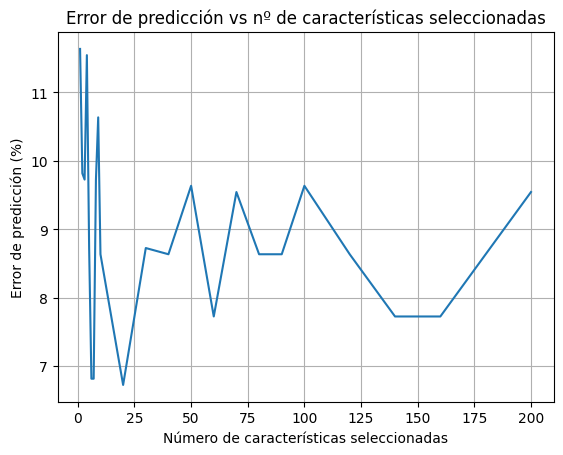

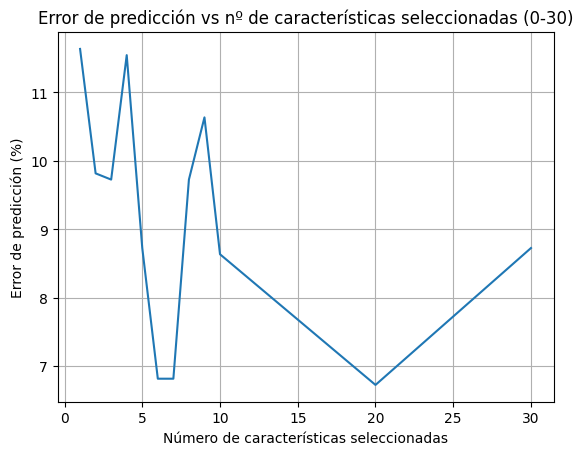

In [9]:
# Representamos el error de predicción según el número de características seleccionadas
plt.plot(feature_range, np.array(mean_errors)*100)
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Error de predicción (%)')
plt.title('Error de predicción vs nº de características seleccionadas')

plt.grid()
plt.show()

# Para ver mejor los 20 primeros:
plt.plot(feature_range[:12], np.array(mean_errors)[:12]*100)
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Error de predicción (%)')
plt.title('Error de predicción vs nº de características seleccionadas (0-30)')

plt.grid()
plt.show()

**2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.**


Para realizar la selección de atributos de forma independiente del proceso de validación cruzada, el selector ha de ser entrenado con el conjunto de datos completo normalizado, antes de realizar la división en conjunto de entrenamiento y test. 

In [10]:
# Definimos el clasificador KNN con K=3
knn = KNeighborsClassifier(n_neighbors=3)
# Indicamos cuántas características seleccionaremos en cada caso
feature_range= np.concatenate([np.arange(1, 10), 
                               np.arange(10, 100, 10),
                               np.arange(100, 201, 20).astype(int)])
# Creamos una lista para almacenar los errores de predicción
mean_errors_2 = []
# Establecemos las condiciones para la validación cruzada
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)   
# Normalizamos el conjunto de datos completo para poder realizar la selección de atributos
scaler1 = preprocessing.StandardScaler().fit(X)
X_scaled = scaler1.transform(X)

for n_features in feature_range:
    
    print(f"Number of features: {n_features}")
    errors = []
    # Entrenamos el selector de atributos con el conjunto de datos completo
    feature_selector = SelectKBest(f_classif, k=n_features).fit(X_scaled, y)

    for train_idx, test_idx in out_cv.split(X, y):
       
        # Generamos los conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # Volvemos a normalizar los datos utilizando solo el conjunto de entrenamiento
        scaler2 = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler2.transform(X_train)
        X_test_scaled = scaler2.transform(X_test)
        # Seleccionamos el número de atributos que queremos utilizando F-score
        X_train_selection = feature_selector.transform(X_train_scaled)
        X_test_selection = feature_selector.transform(X_test_scaled)
        # Entrenamos el clasificador KNN
        knn.fit(X_train_selection, y_train)
        # Hacemos predicciones sobre el conjunto de prueba
        predictions = knn.predict(X_test_selection)
        # Calculamos el error de precisión del modelo
        error = 1 - accuracy_score(y_test, predictions)
        errors.append(error)
    
    mean_errors_2.append(np.mean(errors))


Number of features: 1
Number of features: 2
Number of features: 3
Number of features: 4
Number of features: 5
Number of features: 6
Number of features: 7
Number of features: 8
Number of features: 9
Number of features: 10
Number of features: 20
Number of features: 30
Number of features: 40
Number of features: 50
Number of features: 60
Number of features: 70
Number of features: 80
Number of features: 90
Number of features: 100
Number of features: 120
Number of features: 140
Number of features: 160
Number of features: 180
Number of features: 200


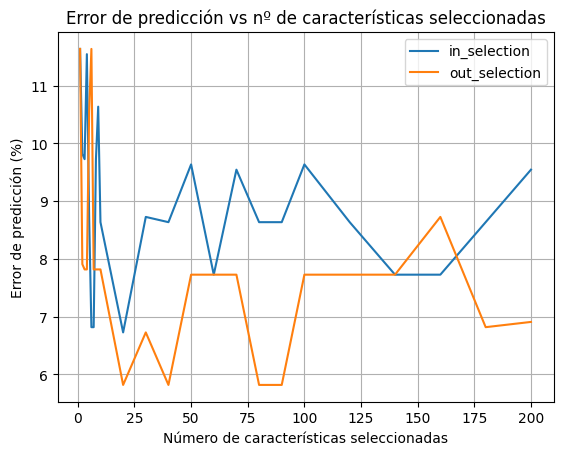

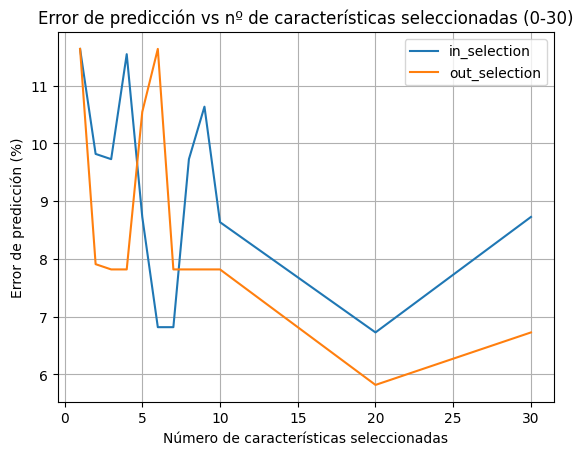

In [11]:
# Representamos el error de predicción según el número de características seleccionadas
plt.plot(feature_range, np.array(mean_errors)*100, label='in_selection')
plt.plot(feature_range, np.array(mean_errors_2)*100, label='out_selection')
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Error de predicción (%)')
plt.title('Error de predicción vs nº de características seleccionadas')
plt.legend()
plt.grid()
plt.show()

# Para ver mejor los 20 primeros:
plt.plot(feature_range[:12], np.array(mean_errors)[:12]*100, label='in_selection')
plt.plot(feature_range[:12], np.array(mean_errors_2)[:12]*100, label='out_selection')
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Error de predicción (%)')
plt.title('Error de predicción vs nº de características seleccionadas (0-30)')
plt.legend()
plt.grid()
plt.show()

**3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.**

En general, el error de predicción es menor cuando la selección de atributos se realiza antes de comenzar el proceso de validación cruzada, aunque esto no quiere decir que sea la forma correcta de operar. 

El menor error de predicción se debe a que para la selección de atributos estamos teniendo en cuenta el conjunto de datos completo, no un subconjunto de entrenamiento. Como consecuencia, se está produciendo un sobreajuste del modelo: funciona bien para este conjunto de datos concreto, pero probablemente funcione peor para otros conjuntos que el modelo que ha sido ajustado utilizando solo un subconjunto de entrenamiento y testado sobre el subconjunto de prueba (del que no tiene ningún tipo de información previa).

<span style="color:red">¿Comentamos algo sobre que cuando el número de características es menor de 10 el error de predicción en ambos casos se encuentra dentro de los mismos límites? Se podría interpretar como una señal de que considerar menos de 10 características dará lugar a predicciones imprecisas en cualquier caso, pero igual metemos la pata :/</span>


**4. By taking a look at these results, what is the optimal number of features to use in this dataset in terms of interpretability vs. prediction error?**

<span style="color:red">Viendo el gráfico, yo diría que 6 o 20. Se supone que hay que encontrar un balance entre el número de características (que ha de ser lo más pequeño posible para que los resultados sean más fáciles de interpretar por los humanos) y el error de predicción (que también debe ser lo más pequeño posible, lo que a veces es difícil de conseguir considerando un número pequeño de características), así que yo no me iría mucho más allá.</span>

**5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features.**

En primer lugar, utilizaremos el conjunto de datos completo normalizado para identificar los atributos más relevantes. A continuación, obtendremos los índices de dichos atributos. Por último, extreremos el nombre correspondiente a cada índice.

In [16]:
selected_feature_indices = SelectKBest(f_classif, k=6).fit(X_scaled, y).get_support(indices=True)

selected_feature_names = data.columns[selected_feature_indices].tolist()

print("Los atributos que deberían ser seleccionados son:")
print(selected_feature_names)

Los atributos que deberían ser seleccionados son:
['1831_at', '34730_g_at', '37639_at', '38028_at', '40024_at', '41468_at']
